In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_parquet('data/fhv_tripdata_2021-01.parquet')

In [3]:
data.shape

(1154112, 7)

In [4]:
data.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [5]:
data['Duration'] = data.dropOff_datetime - data.pickup_datetime

In [6]:
data['Duration'] = data.Duration.apply(lambda dt: dt.total_seconds()/60)
data.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,Duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013,110.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667


In [7]:
data.Duration.mean()

19.167224093791006

C:\Users\jugal\.conda\envs\mlops-zoomcamp\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


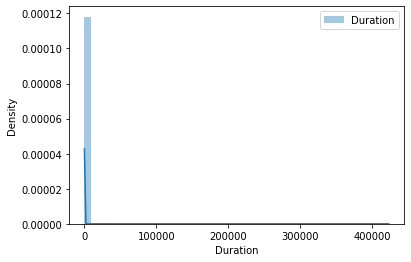

In [8]:
sns.distplot(data.Duration,label='Duration')
plt.legend()

In [10]:
new_data = data.copy()
new_data.shape

(1154112, 8)

In [11]:
new_data = new_data[(new_data.Duration >= 1) & (new_data.Duration <= 60)]
new_data.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,Duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,NaN,71.0,None,B00037,9.050000


In [12]:
new_data.Duration.min(),new_data.Duration.max()

(1.0, 60.0)

In [13]:
dropped_records = data.shape[0] - new_data.shape[0]
dropped_records

44286

In [14]:
features = ['PUlocationID','DOlocationID']
new_data[features] = new_data[features].fillna(-1).astype('int')

In [15]:
(new_data[(new_data.PUlocationID==-1)].shape[0]/new_data.shape[0])* 100

83.52732770722618

In [16]:
new_data[features] = new_data[features].astype('str')

In [17]:

train_data = new_data[features]
labels = new_data.Duration


In [18]:
train_dicts = train_data.to_dict(orient='records')


In [19]:
dv = DictVectorizer()
x_train = dv.fit_transform(train_dicts)


In [21]:
len(dv.feature_names_)

525

In [22]:
lr = LinearRegression()
lr.fit(x_train,labels)

y_pred = lr.predict(x_train)


mean_squared_error(labels,y_pred,squared=False)

10.528519389548583

In [31]:
def read_dataframe(file_name):
    
    if file_name.endswith('.csv'):
        data = pd.read_csv('data/'+file_name)
        
    else:
        data = pd.read_parquet('data/'+file_name)
        
    data['Duration'] = data.dropOff_datetime - data.pickup_datetime
    
    data.Duration = data.Duration.apply(lambda dt: dt.total_seconds()/60)
    
    data = data[(data.Duration >= 1) & (data.Duration <= 60)]
    
    
    features = ['PUlocationID','DOlocationID']
    
    data[features] = data[features].fillna(-1).astype('int')
    
    data[features] = data[features].astype('str')
    
    return data[features+['Duration']]

val_data = read_dataframe('fhv_tripdata_2021-02.parquet')


In [32]:
val_data.head()

,PUlocationID,DOlocationID,Duration
1,173,82,10.666667
2,173,56,14.566667
3,82,129,7.950000
4,-1,225,13.800000
5,-1,61,8.966667


In [33]:
x_val = val_data.drop(columns='Duration')
x_val.head()

,PUlocationID,DOlocationID
1,173,82
2,173,56
3,82,129
4,-1,225
5,-1,61


In [34]:
y_val = val_data.Duration.values

In [35]:
val_dicts = x_val.to_dict(orient='records')
x_valid = dv.transform(val_dicts)

In [36]:
y_pred = lr.predict(x_valid)

mean_squared_error(y_val,y_pred,squared=False)

11.014286585021035